In [1]:
%matplotlib inline
#%matplotlib widget
from astropy.cosmology import LambdaCDM
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm 
from astropy import constants as const
import astropy.units as u
from scipy.integrate import quad
import ezgal # BC03 model maker
import os

# Setup Cosmology

In [2]:
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7, Tcmb0=2.725)

# Create Stellar Population

In [3]:
# check to make sure we have defined the bpz filter path
if not os.getenv('EZGAL_FILTERS'):
    os.environ['EZGAL_FILTERS'] = (f'{os.environ["HOME"]}/Projects/planckClusters/MOSAICpipe/bpz-1.99.3/FILTER/')

model = ezgal.model('bc03_ssp_z_0.02_salp.model')
model = model.make_exponential(1)
model.set_cosmology(Om=cosmo.Om0, Ol=cosmo.Ode0, h=cosmo.h, w=cosmo.w(0))
                                   
model.add_filter('g_MOSAICII.res', name='g')
model.add_filter('r_MOSAICII.res', name='r')
model.add_filter('i_MOSAICII.res', name='i')
model.add_filter('z_MOSAICII.res', name='z')
model.add_filter('K_KittPeak.res', name='K')

# Blanton 2003 Normalization
Mr_star = -20.44 + 5 * np.log10(cosmo.h) # abs mag.
# set the normalization
model.set_normalization('sloan_r', 0.1, Mr_star, vega=False)                                   

/home/boada/.local/lib/python3.6/site-packages/ezgal/data/models/bc03_ssp_z_0.02_salp.model


/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:358: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:360: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/boada/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:361: RuntimeWarning: invalid value encountered in add
  y[slice2]*(2-h0divh1))


# Calculate a few things to get going.

In [4]:
# desired formation redshift
zf = 6.0
# fetch an array of redshifts out to given formation redshift
zs = model.get_zs(zf)
 
# Calculate some cosmological stuff
DM = cosmo.distmod(zs)
dlum = cosmo.luminosity_distance(zs)

# Define the functions that we'll need

Need to compute the cluster volume...

$M_{vir} = 4/3 \pi r^3_{vir} \rho_c(r<r_{vir}) = 4/3 \pi r^3_{vir} \Delta_c \rho_c$

if we let $\Delta_c = 200$ then 

$M_{200} = 4/3 \pi r^3_{200} 200 \rho_c$ with $\rho_c = \frac{3H(z)^2}{8\pi G}$

or just $M_{200} = V_{200}200\rho_c$. So we'll make a function to calculate $\rho_c$. And we'll make use of the astropy units package to do all the unit analysis for us.

Don't forget that $H(z) = H_0E(z)$ 

## We also need to integrate the Schechter luminosity functions..

The Schechter Function:

For Luminosity:

$\Phi(L) = \phi^\star \frac{L}{L_\star}^\alpha e^{-\frac{L}{L_\star}}$

For Magnitudes:

$\Phi(M) = \phi^\star\frac{2}{5}log(10) (10^{\frac{2}{5}(M_\star - M)})^{\alpha+1} e^{-10^{\frac{2}{5}(M_\star - M)}}$




In [5]:
def rho_crit(z, cosmo):
    # convert G into better units:
    G = const.G.to(u.km**2 * u.Mpc/(u.M_sun * u.s**2))
    return 3 / (8 * np.pi * G) * cosmo.H0**2 * cosmo.efunc(z)**2 # Mpc^3

def schechterL(luminosity, phiStar, alpha, LStar): 
    """Schechter luminosity function.""" 
    LOverLStar = (luminosity/LStar) 
    return (phiStar/LStar) * LOverLStar**alpha * np.exp(- LOverLStar) 

def schechterM(magnitude, phiStar, alpha, MStar): 
    """Schechter luminosity function by magnitudes."""
    
    # check to make sure things are all the same size
    if isinstance(phiStar, float) and isinstance(magnitude, np.ndarray):
        phiStar = np.ones_like(magnitude) * phiStar
    if isinstance(alpha , float) and isinstance(magnitude, np.ndarray):
        alpha = np.ones_like(magnitude) * alpha
    if isinstance(MStar, float) and isinstance(magnitude, np.ndarray):
        MStar = np.ones_like(magnitude) * MStar
    
    MStarMinM = 0.4 * (MStar - magnitude)
    return (0.4 * np.log(10) * phiStar * 10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10.**MStarMinM))

# Functions to calculate everything at a specific redshift

In [6]:
def calc_Maglim(mlim, redshift, filter='i', cosmo=cosmo, model=model):
    return mlim - cosmo.distmod(redshift).value - model.get_kcorrects(zf, filters=filter, zs=redshift)
def calc_phistar(redshift, cosmo=cosmo):
    return 3.6 * cosmo.efunc(redshift)**2
def calc_alpha(redshift):
    return -1.05 * (1 + redshift)**(-2 / 3)
def calc_fr(redshift):
    return 0.8 * (1 + redshift)**(-1 / 2)

# Start Calculating things

In [30]:
# So now we are going to calculate the volumes as a function of z

#M200 = mass_func(zarr) * u.solMass

M200 = 1e15 * u.solMass
V200 = M200/ (200 * rho_crit(zs, cosmo))

# Calculate the M_star values
Mstar = model.get_absolute_mags(zf, filters='i', zs=zs)

# calculate the abs mag of our limiting magnitude as a function of z
mlim = 23.5
#Mlim = Mstar - 2.5 * np.log10(0.4)
Mlim = mlim - cosmo.distmod(zs).value - model.get_kcorrects(zf, filters='i', zs=zs)

# Here are the Schechter function stuff from Liu et al.
phi_star = 3.6 * cosmo.efunc(zs)**2
alpha = -1.05 * (1 + zs)**(-2/3)
fr = 0.8*(1 + zs)**(-1/2)

In [8]:
LF = []
for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
    if M_lim < M_star - 2.5 * np.log10(0.4):
        Mlimit = M_lim
    else:
        Mlimit = M_star - 2.5 * np.log10(0.4)
    y, err = quad(schechterM, -30, Mlimit, args=(phi, a, M_star))
    LF.append(y)

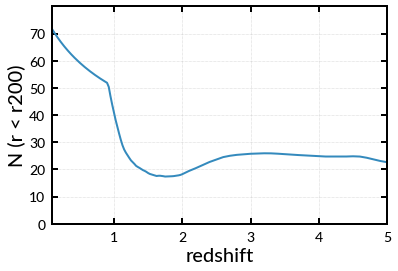

In [9]:
plt.figure()
plt.plot(zs, (LF * V200.value + 1) * fr)
ax = plt.gca()
ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.1, 5)
plt.ylim(0, 80)
plt.xlabel('redshift')
plt.ylabel('N (r < r200)')
plt.grid()

In [10]:
calc_Maglim(23.5, 0.2)

-16.628515739377832

In [11]:
magarr = np.arange(-30, -14, 0.2)

In [12]:
redshifts = np.arange(0.2, 2, 0.2) 
# make some colored lines for the plots
cm_subset = np.linspace(0.2, 0.8, len(redshifts))
colors = [cm.bone(x) for x in cm_subset]

The figure below is where we let both $\phi^\star$ and $\alpha$ evolve with redshift.

The vertical lines show the *faint limit* to our integral. In all cases we are integrating to $M=-30$ mag. So in the function above, we are integrating *from the left to the right* in this figure. 

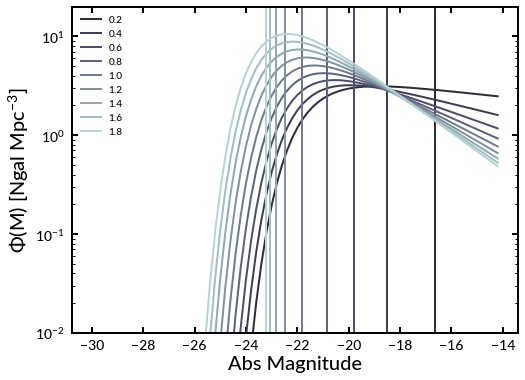

In [13]:
plt.figure(figsize=(8,6))
for z, c in zip(redshifts, colors):
    plt.plot(magarr, schechterM(magarr, calc_phistar(z), calc_alpha(z), model.get_absolute_mags(zf, filters='i', zs=z)), c=c)
    plt.axvline(calc_Maglim(23.5, z), c=c, label=f'{z:.2}')
plt.xlabel('Abs Magnitude')
plt.ylabel('$\Phi(M)$ [Ngal $Mpc^{-3}$]')
plt.semilogy()
plt.ylim(0.01, 20)
plt.legend(loc='upper left')

The figure below is where we fix both $\phi^\star$ and $\alpha$ at some low redshift value, and do not allow them to evolve with redshift.

Here I've fixed them at $z=0.2$.

In my opinion, this looks a lot more like what we would expect for a LF. It still doesn't fully capture the evolution of the LF that I'd expect. I'd expect the 

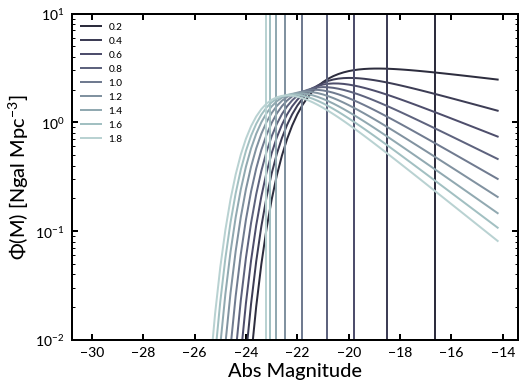

In [14]:
plt.figure(figsize=(8,6))
for z, c in zip(redshifts, colors):
    plt.plot(magarr, schechterM(magarr, calc_phistar(0.2), calc_alpha(z), model.get_absolute_mags(zf, filters='i', zs=z)), c=c)
    plt.axvline(calc_Maglim(23.5, z), c=c, label=f'{z:.2}')
plt.xlabel('Abs Magnitude')
plt.ylabel('$\Phi(M)$ [Ngal $Mpc^{-3}$]')
plt.semilogy()
plt.ylim(0.01, 10)
plt.legend(loc='upper left')

In [52]:
LF = []
for phi, a, M_star, M_lim in zip(phi_star, alpha, Mstar, Mlim):
    if M_lim < M_star - 2.5 * np.log10(0.4):
        Mlimit = M_lim
    else:
        Mlimit = M_star - 2.5 * np.log10(0.4)
    y, err = quad(schechterM, -30, Mlimit, args=(7, -0.8, M_star))
    #print(M_star - M_lim, y)
    LF.append(y)

Here is the above figure, with $\phi^\star$ and $\alpha$ fixed to their $z=0.2$ values.

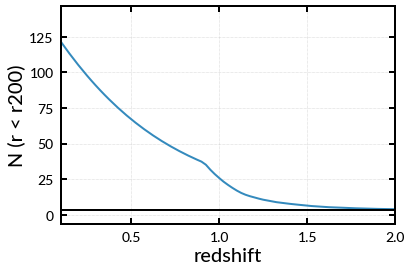

In [53]:
plt.figure()
plt.plot(zs, (LF * V200.value + 1) * fr)
ax = plt.gca()
#ax.set_yticks(np.arange(0, 75, 10))
plt.xlim(0.1, 2)
#plt.ylim(0, 80)
plt.xlabel('redshift')
plt.ylabel('N (r < r200)')
plt.axhline(3)
plt.grid()

In [23]:
LF * V200.value + 1

array([360.90991063, 359.28042458, 357.64962801, 356.01767866,
       354.38473317, 352.75094699, 351.1164744 , 349.48146843,
       347.84608083, 346.21046206, 344.57476119, 342.93912595,
       341.30370263, 339.66863608, 338.03406966, 336.40014522,
       334.76700308, 333.13478201, 331.50361915, 329.87365006,
       321.74633934, 313.66823857, 305.65435579, 297.71856597,
       289.87358771, 282.13097547, 274.50112548, 266.99329392,
       259.6156256 , 252.37519146, 245.27803334, 238.32921441,
       231.53287402, 224.89228539, 218.40991532, 212.0874846 ,
       205.92602842, 199.92595601, 194.08710875, 188.40881644,
       182.8899512 , 177.52897873, 172.32400672, 167.27283029,
       162.37297438, 157.62173303, 153.0162056 , 148.55333008,
       144.22991337, 140.04265893, 135.98819162, 132.06308019,
       124.62387252, 111.68619887, 100.43002174,  90.47143393,
        80.95658235,  72.82278658,  65.31209292,  58.44757696,
        52.51903425,  47.91412591,  44.43216167,  41.44

In [32]:
Mpiv = 6e14
zpiv = 0.46

fr2 = 0.68 * (M200.value / Mpiv)**-0.1 * ((1 + zs)/ (1 + zpiv))** -0.65

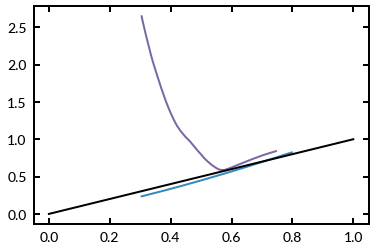

In [44]:
plt.plot(fr, fr2)
plt.plot(fr, fr3)
plt.plot([0,1], [0,1], c='k')

In [41]:
from scipy.special import erf

N200 = LF * V200.value + 1

gz = 0.206 - 0.371 * zs
hz = -3.6 + 25.8 * zs

fr3 = gz * erf(np.log10(N200) - np.log10(hz)) + 0.69

/home/boada/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log10
  


In [42]:
fr3

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.84034781, 0.83102449, 0.82163418, 0.81219032,
       0.80270987, 0.79320968, 0.78370595, 0.77421438, 0.76475025,
       0.75532861, 0.74596434, 0.73667226, 0.72746715, 0.71836375,
       0.70937683, 0.7005211 , 0.69181125, 0.68326189, 0.67488752,
       0.66670251, 0.65872103, 0.65095702, 0.64342415, 0.63613575,
       0.62910481, 0.62234389, 0.61586512, 0.60968012, 0.60380002,
       0.59823535, 0.59299609, 0.58912007, 0.58799143, 0.5879358 ,
       0.58905226, 0.59190517, 0.59585794, 0.60147692, 0.60879097,
       0.61726965, 0.62569085, 0.6335974 , 0.64183236, 0.65097884,
       0.66098736, 0.67009332, 0.68011027, 0.69148789, 0.70109453,
       0.71081316, 0.72159564, 0.73267446, 0.74319792, 0.75482

In [43]:
fr2

array([0.82365522, 0.82100254, 0.81837144, 0.81576165, 0.81317287,
       0.81060485, 0.80805732, 0.80553001, 0.80302267, 0.80053505,
       0.79806689, 0.79561797, 0.79318803, 0.79077683, 0.78838416,
       0.78600979, 0.78365348, 0.78131501, 0.77899419, 0.77669078,
       0.76542784, 0.75457046, 0.74409568, 0.7339823 , 0.7242107 ,
       0.71476271, 0.70562145, 0.69677124, 0.68819747, 0.67988654,
       0.67182574, 0.6640032 , 0.6564078 , 0.64902913, 0.64185744,
       0.63488355, 0.62809885, 0.62149522, 0.61506502, 0.60880107,
       0.60269655, 0.59674506, 0.59094052, 0.58527719, 0.57974963,
       0.57435269, 0.56908149, 0.56393139, 0.55889797, 0.55397705,
       0.54916464, 0.54445696, 0.53985039, 0.53534148, 0.53092696,
       0.52660369, 0.52236868, 0.51821906, 0.51415212, 0.51016523,
       0.50625589, 0.50242171, 0.49866039, 0.49496974, 0.49134765,
       0.48779209, 0.48430113, 0.4808729 , 0.4775056 , 0.47419753,
       0.47094701, 0.46775247, 0.46461236, 0.46152522, 0.45848

In [54]:
calc_phistar(0.2)

4.386434445930736

In [46]:
phi_star

array([  3.61628424,   3.63273137,   3.6493422 ,   3.66611754,
         3.6830582 ,   3.70016499,   3.71743872,   3.73488021,
         3.75249026,   3.77026968,   3.78821929,   3.8063399 ,
         3.82463232,   3.84309735,   3.86173582,   3.88054852,
         3.89953628,   3.9186999 ,   3.9380402 ,   3.95755798,
         4.05783755,   4.16267589,   4.2721744 ,   4.38643445,
         4.50555743,   4.62964473,   4.75879774,   4.89311787,
         5.03270649,   5.17766503,   5.32809488,   5.48409745,
         5.64577414,   5.81322637,   5.98655557,   6.16586313,
         6.35125049,   6.54281907,   6.7406703 ,   6.9449056 ,
         7.15562641,   7.37293417,   7.5969303 ,   7.82771627,
         8.0653935 ,   8.31006345,   8.56182756,   8.82078729,
         9.08704409,   9.36069943,   9.64185476,   9.93061155,
        10.22707127,  10.53133538,  10.84350536,  11.16368269,
        11.49196884,  11.82846529,  12.17327353,  12.52649505,
        12.88823134,  13.25858389,  13.63765419,  14.02